# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [20]:
fto = '/storage/experiments/2021/03_REFLECT3/AirdosCvetsiNaITl_9c/DATALOG.TXT' #  File to Open
fto = '/storage/experiments/2021/0609_bourka_sobeslav/GEODOS/BF/DATALOG.TXT' #  File to Open
#fto = '/storage/experiments/2021/0605_bourka_radosovice/GEODOS/BF/DATALOG.TXT' #  File to Open
fto = '/storage/experiments/2021/10_test_geodos_cernobyl/DATALOG.TXT'
fto = '/storage/experiments/2021/10_test_geodos_cernobyl/Na22/DATALOG.TXT'
fto = '/storage/experiments/2021/10_test_geodos_cernobyl/background_odz/DATALOG.TXT'
#fto = '/storage/experiments/2021/10_test_geodos_cernobyl/balon_background_odz/DATALOG.TXT'
fto = '/storage/stations/Cernobyl/let04.10.2021/DATALOG.TXT'
fto = '/storage/stations/Cernobyl/06102021/DATALOG.TXT'

l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn.iloc[0])
print ('f.v.: ',fw.iloc[0])
print(df.loc[df[0]=='$AIRDOS',1].iloc[0])
print(len(df))
print(last[-1:][0])

df.drop(df.index[:last[-1:][0]], inplace=True) # keep only last run

s.n.:  1290c00806a200923c12a000a00000bf
f.v.:  a1bf671
CERNOBYL
6916
3901


## Fill position and time

In [20]:
#df.drop(df.loc[(df[0]=='$GPRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GPRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GPRMC',1]
df['gps_date'] = df.loc[df[0]=='$GPRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GPRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GPRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GPRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df


,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,alt,lat,lon,meas,UTC
31,$GLGSV,3,1,10,67,04,219,NaN,68,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
32,$GLGSV,3,2,10,77,55,074,NaN,78,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
33,$GLGSV,3,3,10,87,52,108,NaN,88,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
34,$GNGLL,4915.64443,N,01441.50401,E,220306.00,A,A,88,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
35,$GNRMC,220307.00,A,4915.64568,N,01441.50327,E,0.667,88,300921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15532,$HITS,0,130102.75,96753.25,20.75,4.06,-17,758,955,22.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7722,NaT
15533,$HIST,7723,130119.98,96753.25,20.75,4.06,-17,758,955,22.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7723,NaT
15534,$HITS,0,130119.98,96753.25,20.75,4.06,-17,758,955,22.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7723,NaT
15535,$HIST,7724,130136.93,96749.50,20.69,4.06,-17,758,955,22.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7724,NaT


## Galileo support

In [21]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df


,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,alt,lat,lon,meas,UTC
3910,$GNVTG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3911,$GNGGA,103720.00,NaN,NaN,NaN,NaN,0,00,99.99,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3912,$GNGSA,A,1,NaN,NaN,NaN,0,00,99.99,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3913,$GNGSA,A,1,NaN,NaN,NaN,0,00,99.99,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3916,$GLGSV,1,1,03,NaN,NaN,0,23,99.99,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922,$HITS,0,25283.63,101891.00,19.44,3.90,-17,709,966,21.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1499,2021-10-05 17:37:35.690
6923,$HIST,1500,25300.57,101887.50,19.44,3.89,-17,709,966,21.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,2021-10-05 17:37:52.630
6924,$HITS,0,25300.57,101887.50,19.44,3.89,-17,709,966,21.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,2021-10-05 17:37:52.630
6925,$HIST,1501,25317.50,101885.00,19.50,3.91,-17,708,966,21.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,2021-10-05 17:38:09.560


## Add individual events to histogram

In [22]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:270].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,12:269] = 0
hist.set_index('meas', inplace=True)
hits = df.loc[df[0]=='$HITS'].copy()
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits.set_index('meas', inplace=True)


In [5]:
for index, row in hits.iterrows():
    for j in range(2,2+row[1]*2,2):
        hist.loc[index,int(row[j+1])+3] += 1


In [6]:
df.iloc[:,10:30]

,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
3923,40476,25037.0,5,3.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3924,40476,25037.0,5,3.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3925,41866,23651.0,3,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3926,41866,23651.0,3,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3927,42218,23292.0,7,3.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922,47667,17848.0,4,5.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6923,45260,20252.0,5,3.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6924,45260,20252.0,5,3.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6925,46455,19053.0,7,3.0,5.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df.drop(df[df[0]=='$HITS'].index, inplace=True)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df.drop(df[df[0]=='$GNVTG'].index, inplace=True)
df.drop(df[df[0]=='$GNGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNGSA'].index, inplace=True)
df.drop(df[df[0]=='$GNGSV'].index, inplace=True)
df.drop(df[df[0]=='$GNGLL'].index, inplace=True)
df.drop(df[df[0]=='$GLGSV'].index, inplace=True)

df.loc[df[0]!='$HIST']

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,alt,lat,lon,meas,UTC


In [8]:
NOISE_LEVEL = 12
LAST_CHANNEL = 250
df['flux'] = (df.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

Text(0, 0.5, 'Counts')

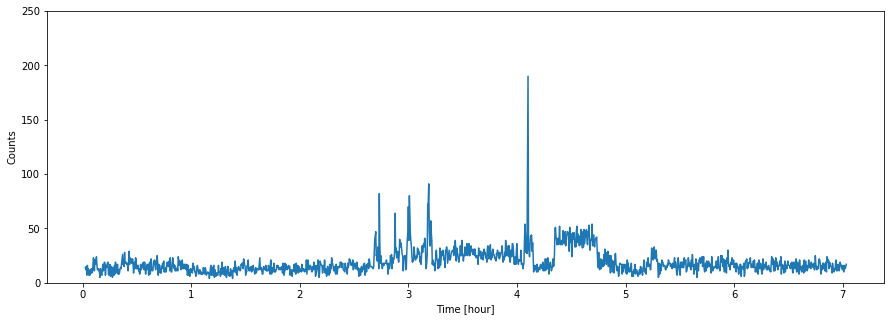

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df[2].astype('float')/60/60,df['flux'])
#plt.locator_params(nbins=10)
plt.ylim([0,250])
plt.xlabel('Time [hour]')
plt.ylabel('Counts')


Text(0, 0.5, 'Counts')

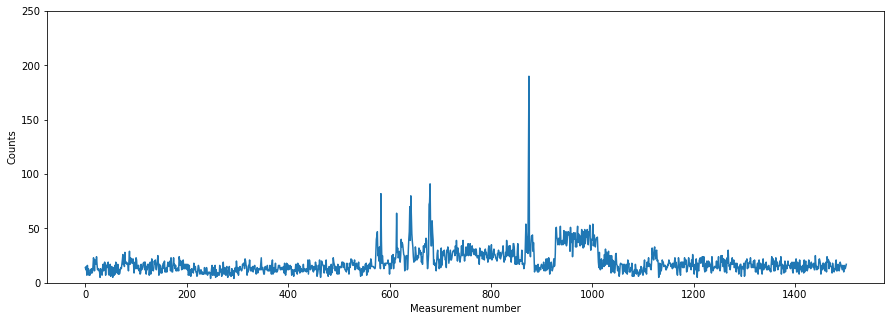

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df[1].astype('float'),df['flux'])
#plt.locator_params(nbins=10)
plt.ylim([0,250])
plt.xlabel('Measurement number')
plt.ylabel('Counts')


In [301]:
#xx = df.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
xx = df
xx = xx.iloc[:,12:250].astype('float')
ener1 = xx.iloc[600:700,:].sum()
#ener1 = xx.iloc[-1000:,:].sum()
e = pd.DataFrame()
e['1'] = ener1
e['index'] = pd.to_numeric(ener1.index)
e.set_index('index',inplace=True)

Text(0, 0.5, 'Counts')

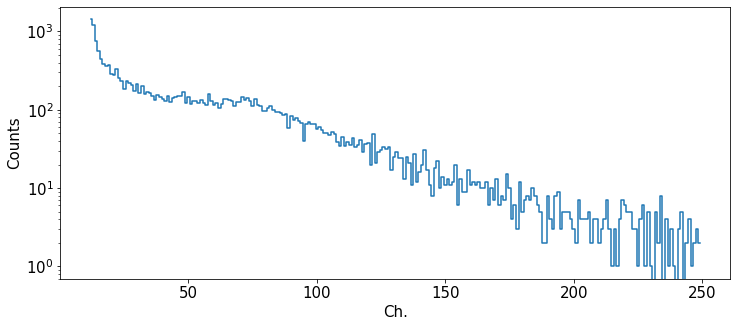

In [302]:
plt.figure(figsize=(12,5))
plt.plot(ener1, drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.xlim([0,120])

In [294]:
xx

,12,13,14,15,16,17,18,19,20,21,...,240,241,242,243,244,245,246,247,248,249
905,6.0,4.0,3.0,4.0,3.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907,4.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,6.0,7.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,1.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913,4.0,6.0,2.0,3.0,2.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,9.0,6.0,6.0,1.0,3.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3893,5.0,7.0,4.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3895,3.0,3.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3897,9.0,1.0,8.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


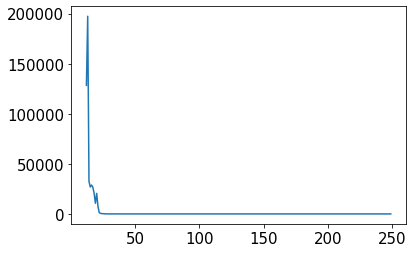

In [213]:
#xx.iloc[-2:,12:30]
#ener1 = xx.iloc[-2:,:250].sum()

#xx
#ener1
#xx.iloc[100:200,NOISE_LEVEL:250]
#e[0:]
#print(xx.iloc[-2:,12:30])
plt.plot(ener1)
#xx.iloc[:,0:250]

## Plot Flux

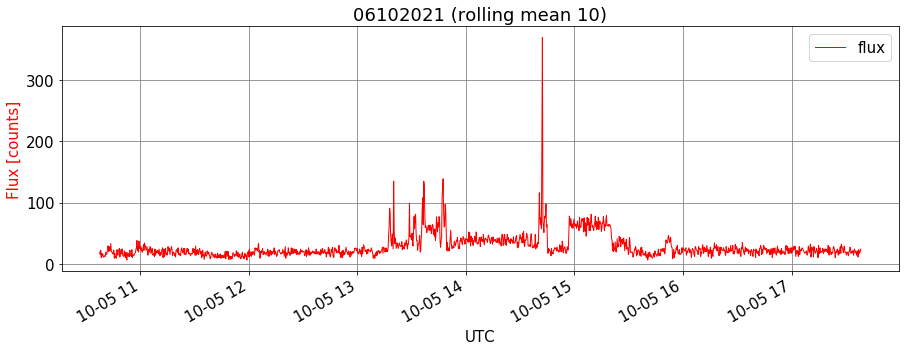

In [32]:
NOISE_LEVEL = 12
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='red', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

'''
ax = plt.twinx()

#plt.ylim([0,14000])
#xx['alt'].plot(c='b', label='alt', marker='.', ms=2, linewidth='2', linestyle='none', drawstyle='steps-mid')
xx['alt'].plot(c='b', label='alt', marker='.', ms=2, linewidth='2', drawstyle='steps-mid')
plt.ylabel('altitude a.s.l. [m]', color='blue')
'''
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



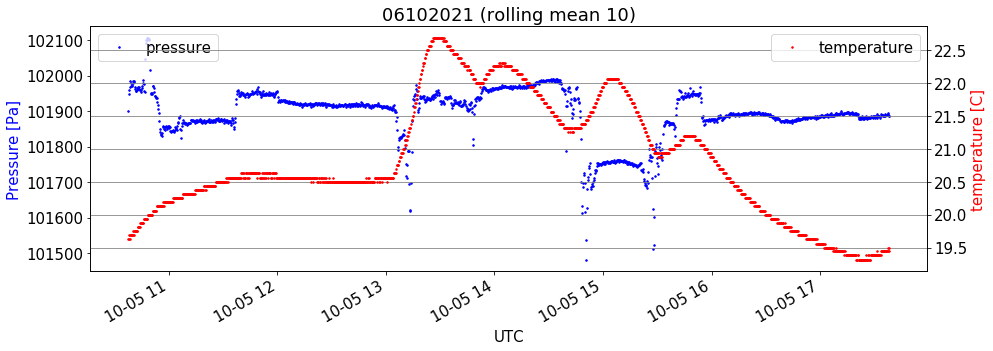

In [15]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



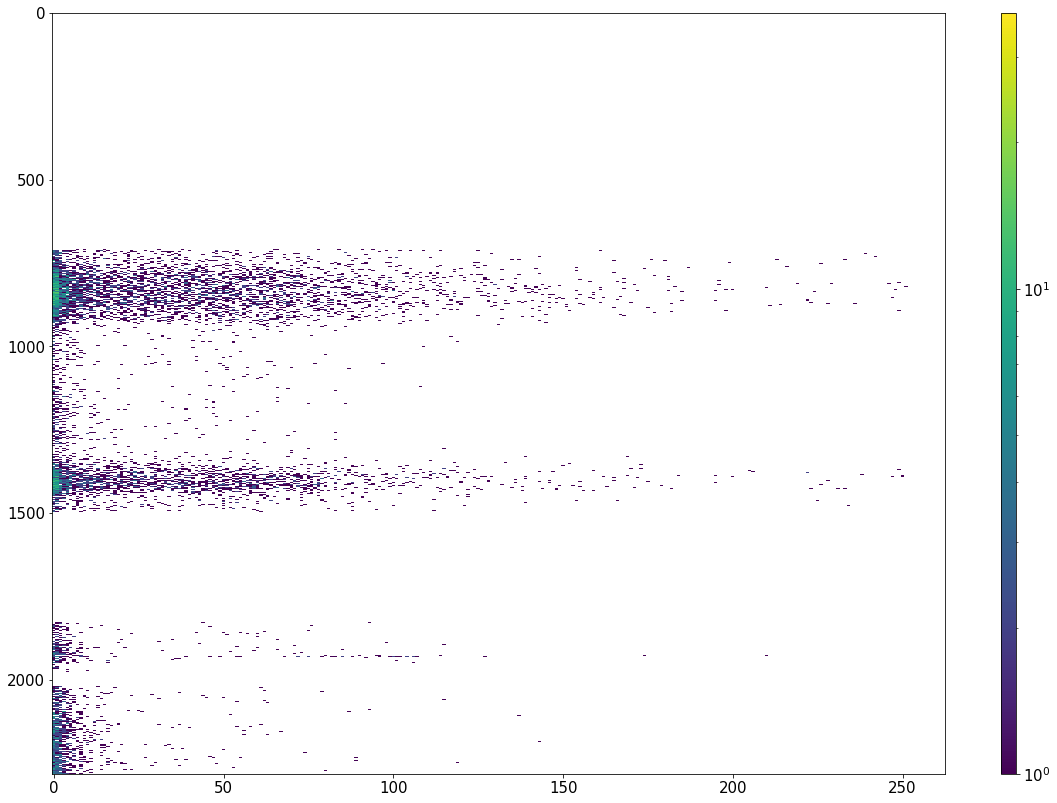

In [18]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((hist.iloc[:,7:270]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

In [16]:

hist['2021-03-24 13:00:00':'2021-03-24 13:01:00'].iloc[:,7:]


,7,8,9,10,11,12,13,14,15,16,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-03-24 13:00:19.550,10,6,2,4,3.0,2,1,1,1,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:19.550,91.0,97.0
2021-03-24 13:00:29.050,6,8,5,3,5.0,1,1,0,3,3,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:29.050,110.0,98.0
2021-03-24 13:00:38.800,6,7,3,3,3.0,3,4,0,2,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:38.800,90.0,98.1
2021-03-24 13:00:48.140,10,7,9,8,3.0,2,3,0,3,2,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:48.140,101.0,98.0
2021-03-24 13:00:57.710,10,8,2,5,4.0,1,2,2,1,1,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:57.710,106.0,99.5


In [240]:
# balon
#xx = df.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
xx = df
xx = xx.iloc[1:,14:250].astype('float')
ener1 = xx.iloc[100:1000,:].sum()
#ener1 = xx.iloc[-1000:,:].sum()
e = pd.DataFrame()
e['1'] = ener1
e['index'] = pd.to_numeric(ener1.index)
e.set_index('index',inplace=True)

In [19]:
df.iloc[:,11:]

,11,12,13,14,15,16,17,18,19,20,...,495,496,497,498,499,alt,lat,lon,meas,UTC
3923,25037.0,5,3.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2021-10-05 10:37:36.810
3924,25037.0,5,3.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2021-10-05 10:37:36.810
3925,23651.0,3,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2021-10-05 10:37:53.740
3926,23651.0,3,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2021-10-05 10:37:53.740
3927,23292.0,7,3.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2021-10-05 10:38:10.560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922,17848.0,4,5.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1499,2021-10-05 17:37:35.690
6923,20252.0,5,3.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,2021-10-05 17:37:52.630
6924,20252.0,5,3.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,2021-10-05 17:37:52.630
6925,19053.0,7,3.0,5.0,2.0,0.0,2.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501,2021-10-05 17:38:09.560
